<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Pipeline" data-toc-modified-id="Pipeline-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Pipeline</a></span><ul class="toc-item"><li><span><a href="#Without-pipeline" data-toc-modified-id="Without-pipeline-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Without pipeline</a></span></li><li><span><a href="#With-pipeline-(lite-version)" data-toc-modified-id="With-pipeline-(lite-version)-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>With pipeline (lite version)</a></span></li><li><span><a href="#ColumnTransformer" data-toc-modified-id="ColumnTransformer-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>ColumnTransformer</a></span></li></ul></li><li><span><a href="#Pipeline-+-GridSearchCV" data-toc-modified-id="Pipeline-+-GridSearchCV-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Pipeline + GridSearchCV</a></span><ul class="toc-item"><li><span><a href="#Hard-version-Pipeline" data-toc-modified-id="Hard-version-Pipeline-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Hard version Pipeline</a></span></li></ul></li></ul></div>

# Подготовка

In [ ]:
# !pip install -q pyod
# !pip install -q feature_engine
# !pip install -q imbalanced-learn

In [1]:
import warnings
warnings.filterwarnings('ignore')
from collections import Counter

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams, rcParamsDefault

In [2]:
rcParams['figure.figsize'] = 8,8
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline
factor = 1
default_dpi = rcParamsDefault['figure.dpi']
rcParams['figure.dpi'] = default_dpi*factor

pd.options.display.max_colwidth = 50
pd.options.display.max_columns = 20
pd.options.display.max_columns = 50

# Pipeline

**Links:**
1. Improve Your Data Preprocessing with ColumnTransformer and Pipelines - https://towardsdatascience.com/improve-your-data-preprocessing-with-columntransformer-and-pipelines-b6ff7edd2f77

2. Sklearn Piplines - https://scikit-learn.org/stable/modules/compose.html#pipeline
3. Data preprocessing in sklearn - https://scikit-learn.org/stable/modules/preprocessing.html?highlight=functiontransform
4. Make custom sampler - https://imbalanced-learn.org/stable/auto_examples/applications/plot_outlier_rejections.html?highlight=functionsampler
5. How to create custom transformer for sklearn Pipeline - https://towardsdatascience.com/customizing-sklearn-pipelines-transformermixin-a54341d8d624
6. Parameters tunning in GridSearchCV Pipeline - https://towardsdatascience.com/getting-the-most-out-of-scikit-learn-pipelines-c2afc4410f1a

7. Pipelines & Custom Transformers in scikit-learn: The step-by-step guide - https://towardsdatascience.com/pipelines-custom-transformers-in-scikit-learn-the-step-by-step-guide-with-python-code-4a7d9b068156
8. How to Improve Machine Learning Code - https://www.freecodecamp.org/news/machine-learning-pipeline/

**Этапы предобработки датасета**

1. Кодирование - категориальные
2. Масштабирование - числовые
3. Заполнение пропусков - по всем признакам
4. Поиск выбросов - по всем признакам
5. Добавление полиномиальных признаков - числовые
6. Проверка на корреляцию - числовые
7. Удаление не значимых признаков - все
8. Сэмплирование - все

---------------------------------------
9. Подбор походящей модели

## Without pipeline

In [3]:
data = sns.load_dataset('tips')
data

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [4]:
X = data.drop(columns='tip')
y = data.tip
X.head()

,total_bill,sex,smoker,day,time,size
0,16.99,Female,No,Sun,Dinner,2
1,10.34,Male,No,Sun,Dinner,3
2,21.01,Male,No,Sun,Dinner,3
3,23.68,Male,No,Sun,Dinner,2
4,24.59,Female,No,Sun,Dinner,4


In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   total_bill  244 non-null    float64 
 1   sex         244 non-null    category
 2   smoker      244 non-null    category
 3   day         244 non-null    category
 4   time        244 non-null    category
 5   size        244 non-null    int64   
dtypes: category(4), float64(1), int64(1)
memory usage: 5.5 KB


In [6]:
cat_columns = X.select_dtypes(include='category').columns
num_columns = X.select_dtypes(include='number').columns

In [7]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((195, 6), (49, 6))

In [8]:
scaler = StandardScaler()
encoder = OneHotEncoder(drop='first', sparse=False)
model = Ridge(random_state=42)

X_train_scaled  = scaler.fit_transform(X_train[num_columns])
X_test_scaled = scaler.transform(X_test[num_columns])

X_train_ohe = encoder.fit_transform(X_train[cat_columns])
X_test_ohe = encoder.transform(X_test[cat_columns])

X_train = np.hstack((X_train_scaled, X_train_ohe))
X_test = np.hstack((X_test_scaled, X_test_ohe))

X_train.shape, X_test.shape

((195, 8), (49, 8))

In [9]:
model.fit(X_train, y_train)

Ridge(random_state=42)

In [10]:
X_test.shape, y_test.shape

((49, 8), (49,))

In [11]:
preds = model.predict(X_test)
mean_absolute_error(y_test, preds)

0.66685917327475

## With pipeline (lite version)

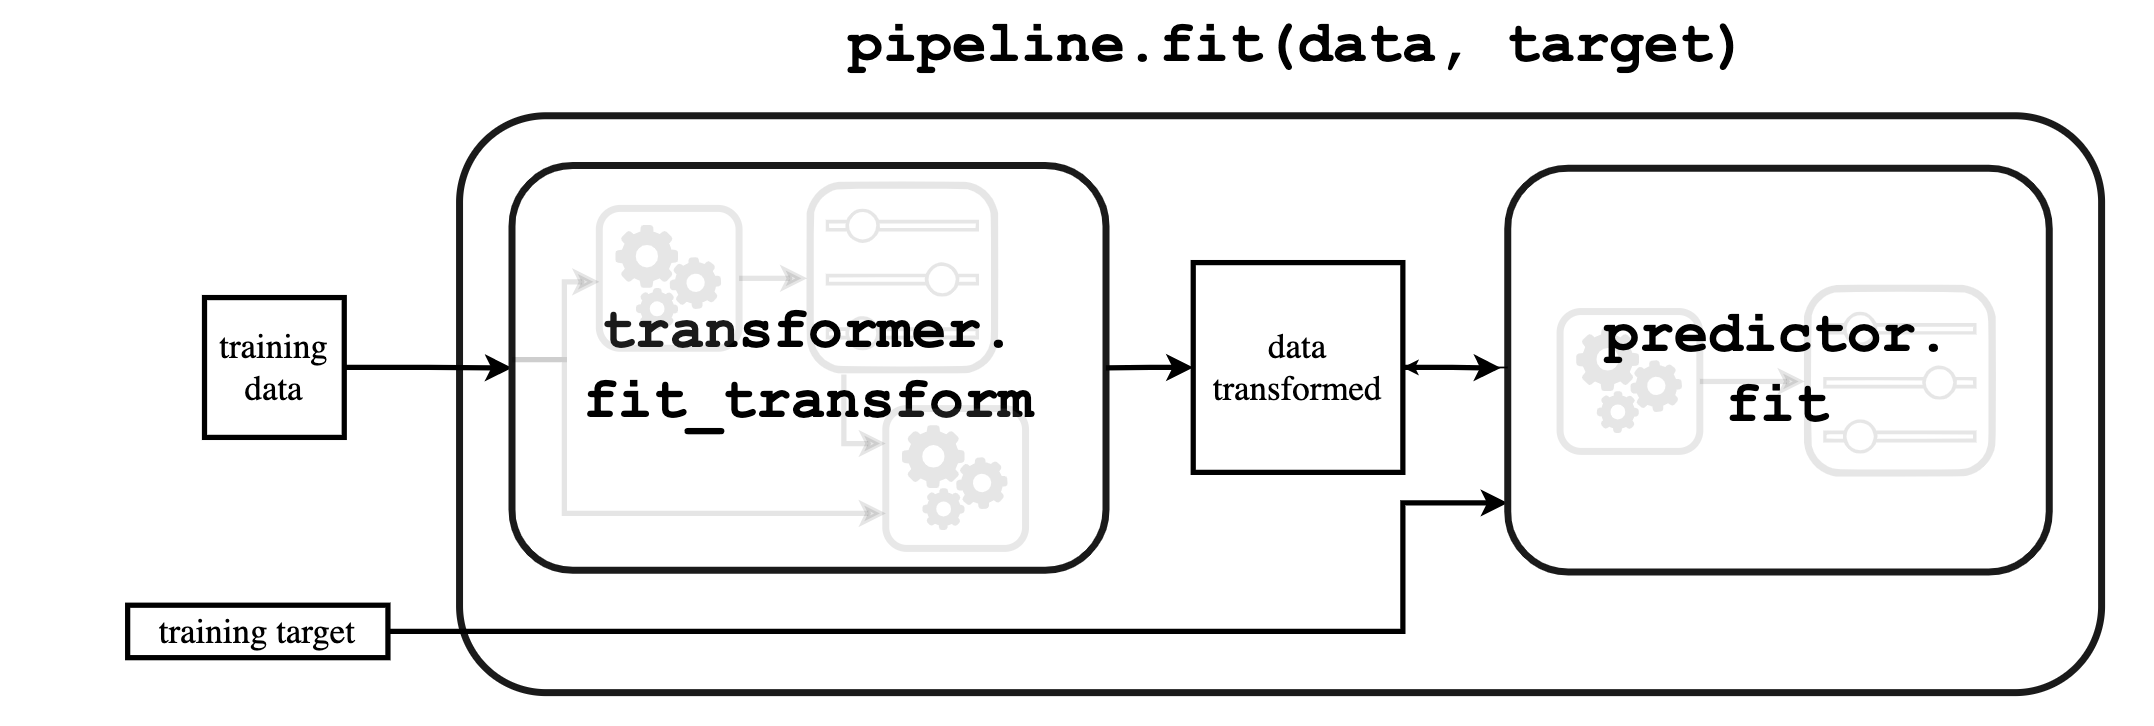

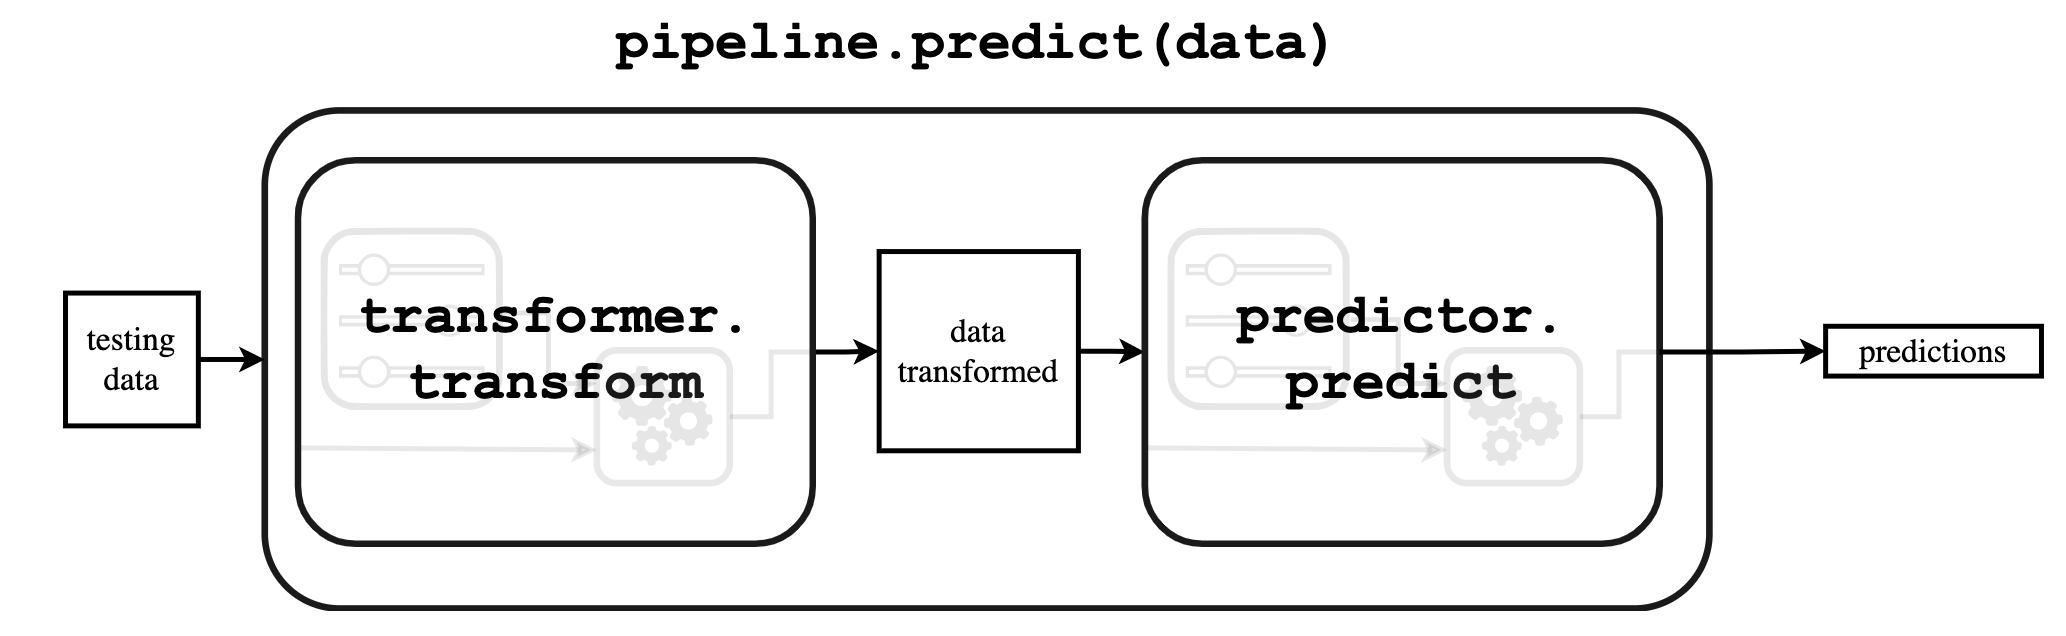

In [12]:
from sklearn.pipeline import Pipeline, make_pipeline

pipeline = Pipeline([
                     ('encoder', OneHotEncoder(drop='first')),
                     ('scaler', StandardScaler()), 
                     ('model', Ridge())])
pipeline


Pipeline(steps=[('encoder', OneHotEncoder(drop='first')),
                ('scaler', StandardScaler()), ('model', Ridge())])

In [13]:
pipeline_make = make_pipeline(StandardScaler(), OneHotEncoder(), Ridge())
pipeline_make

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('onehotencoder', OneHotEncoder()), ('ridge', Ridge())])

## ColumnTransformer

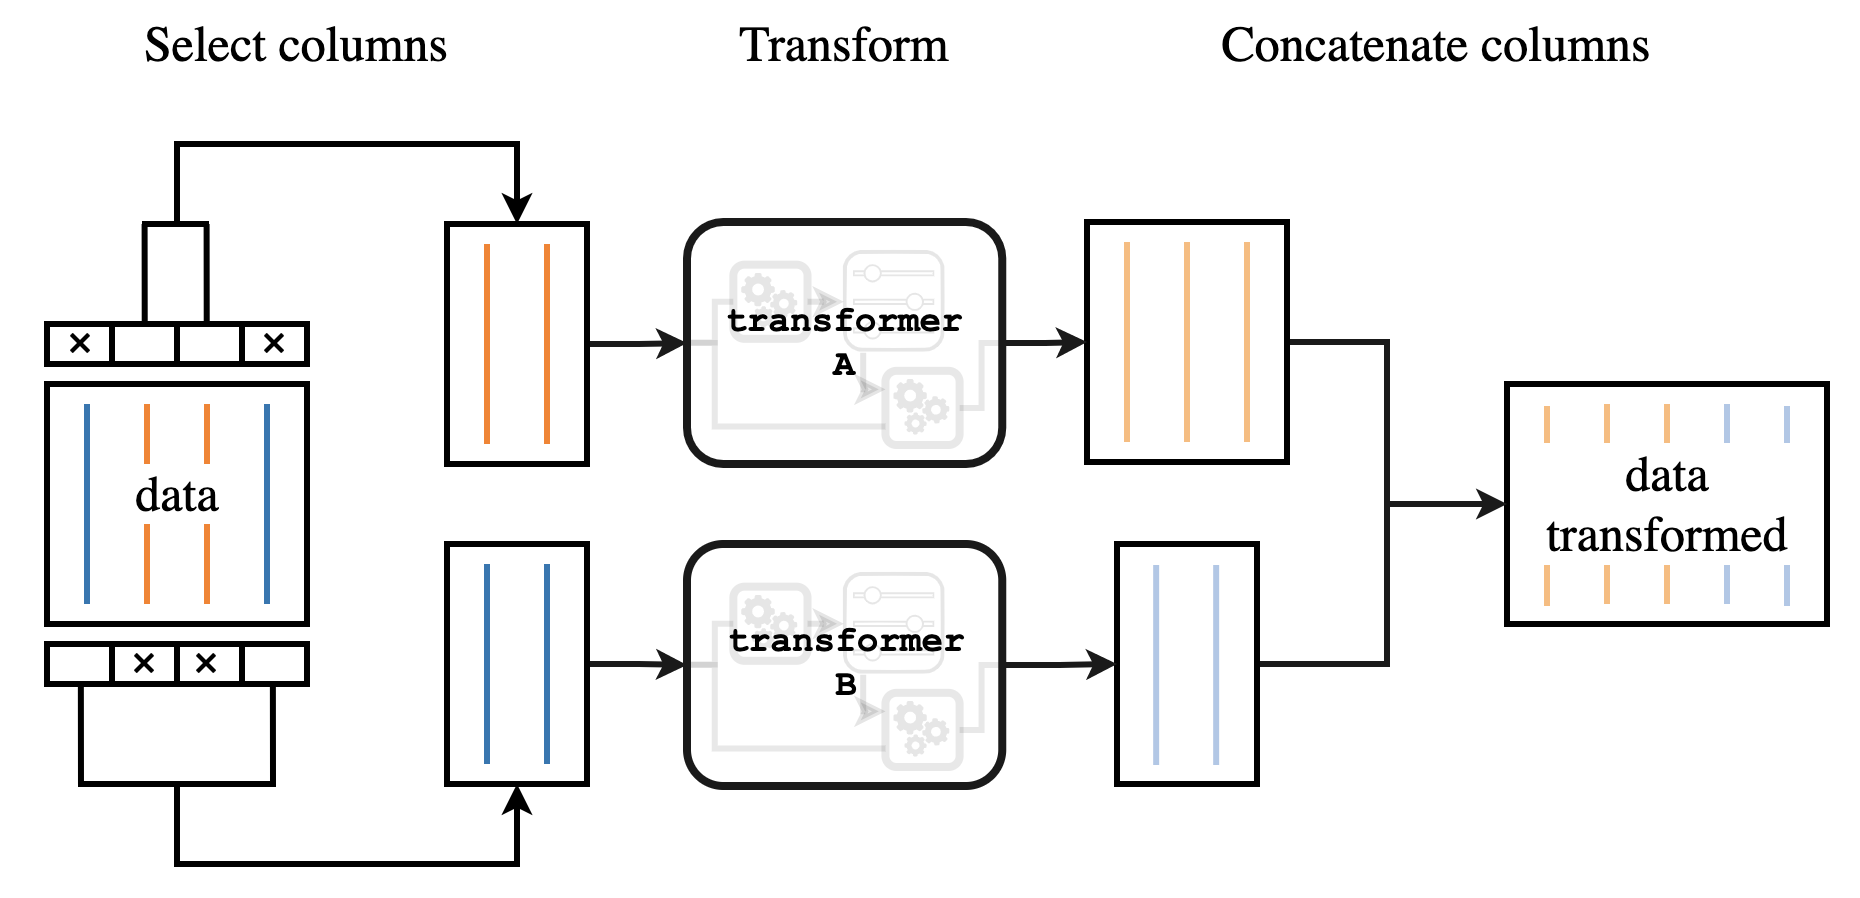

In [14]:
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer


data = sns.load_dataset('tips')
# data['size'] = data['size'].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   total_bill  244 non-null    float64 
 1   tip         244 non-null    float64 
 2   sex         244 non-null    category
 3   smoker      244 non-null    category
 4   day         244 non-null    category
 5   time        244 non-null    category
 6   size        244 non-null    int64   
dtypes: category(4), float64(2), int64(1)
memory usage: 7.4 KB


In [15]:
X = data.drop(columns='tip')
y = data.tip
X.head()

,total_bill,sex,smoker,day,time,size
0,16.99,Female,No,Sun,Dinner,2
1,10.34,Male,No,Sun,Dinner,3
2,21.01,Male,No,Sun,Dinner,3
3,23.68,Male,No,Sun,Dinner,2
4,24.59,Female,No,Sun,Dinner,4


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [17]:
column_transformer = make_column_transformer((StandardScaler(), make_column_selector(dtype_include='number')),
                                             (OneHotEncoder(drop='first'), make_column_selector(dtype_include='category')),
                                              remainder='passthrough')
column_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fe9e014f9d0>),
                                ('onehotencoder', OneHotEncoder(drop='first'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fe9e014f940>)])

In [18]:
model = Ridge(random_state=42)
pipeline = make_pipeline(column_transformer, model)
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe9e014f9d0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe9e014f940>)])),
                ('ridge', Ridge(random_state=42))])

In [19]:
cat_columns = X.select_dtypes(include='category').columns.tolist()
num_columns = X.select_dtypes(include='number').columns.tolist()
cat_columns

['sex', 'smoker', 'day', 'time']

In [20]:
column_transformer = make_column_transformer((StandardScaler(), num_columns),
                                             (OneHotEncoder(drop='first'), cat_columns),
                                              remainder='passthrough')  
model = Ridge(random_state=42)
pipeline = make_pipeline(column_transformer, model)
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['total_bill', 'size']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['sex', 'smoker', 'day',
                                                   'time'])])),
                ('ridge', Ridge(random_state=42))])

In [21]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['total_bill', 'size']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['sex', 'smoker', 'day',
                                                   'time'])])),
                ('ridge', Ridge(random_state=42))])

In [22]:
preds = pipeline.predict(X_test)
mean_absolute_error(y_test, preds)

0.6964608552028416

In [24]:
pipeline.steps

[('columntransformer',
  ColumnTransformer(remainder='passthrough',
                    transformers=[('standardscaler', StandardScaler(),
                                   ['total_bill', 'size']),
                                  ('onehotencoder', OneHotEncoder(drop='first'),
                                   ['sex', 'smoker', 'day', 'time'])])),
 ('ridge', Ridge(random_state=42))]

In [28]:
pipeline.steps[1][1].coef_

array([ 0.87983819,  0.19696436,  0.02715401, -0.26630417, -0.12622919,
       -0.09145326, -0.16544906,  0.14746445])

In [29]:
pipeline.named_steps['ridge']

Ridge(random_state=42)

In [30]:
pipeline.named_steps['ridge'].coef_

array([ 0.87983819,  0.19696436,  0.02715401, -0.26630417, -0.12622919,
       -0.09145326, -0.16544906,  0.14746445])

In [31]:
feature_importance = pipeline.named_steps['ridge'].coef_
feature_names = column_transformer.get_feature_names_out()
feature_names

array(['standardscaler__total_bill', 'standardscaler__size',
       'onehotencoder__sex_Male', 'onehotencoder__smoker_Yes',
       'onehotencoder__day_Sat', 'onehotencoder__day_Sun',
       'onehotencoder__day_Thur', 'onehotencoder__time_Lunch'],
      dtype=object)

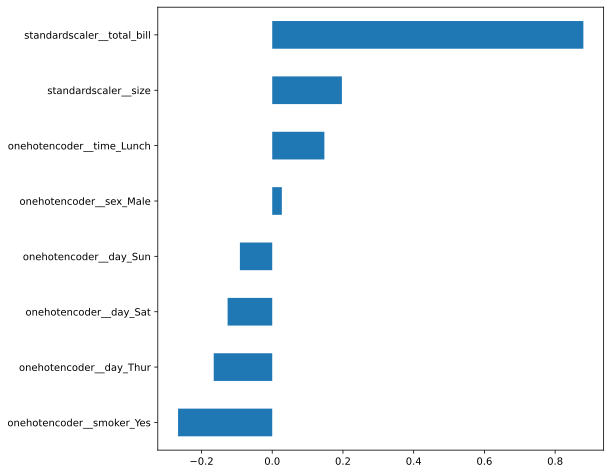

In [32]:
_ = pd.Series(feature_importance, index=feature_names).sort_values().plot(kind='barh')


# Pipeline + GridSearchCV

In [33]:
pipeline.named_steps

{'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('standardscaler', StandardScaler(),
                                  ['total_bill', 'size']),
                                 ('onehotencoder', OneHotEncoder(drop='first'),
                                  ['sex', 'smoker', 'day', 'time'])]),
 'ridge': Ridge(random_state=42)}

In [34]:
from sklearn.preprocessing import MinMaxScaler

params = {
          'columntransformer__standardscaler': [StandardScaler(), MinMaxScaler()],
          'ridge__alpha': range(0,10,1),
         }

grid = GridSearchCV(pipeline, params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X_train, y_train, )

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['total_bill',
                                                                          'size']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'day',
                                                                          'time'])])),
                                       ('ridge', Ridge(random_state=42))]),
             param_grid={'columntransformer__standardscaler': [StandardScaler(),
                                                               MinMaxScaler()],
                         'ridge__alpha': range(0, 10)},
             scoring='neg_mean_absolute_error')

In [35]:
grid.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['total_bill', 'size']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['sex', 'smoker', 'day',
                                                   'time'])])),
                ('ridge', Ridge(alpha=9, random_state=42))])

In [36]:
grid.best_score_

-0.8183378016243672

In [37]:
grid.best_params_

{'columntransformer__standardscaler': StandardScaler(), 'ridge__alpha': 9}

In [38]:
grid.cv_results_

{'mean_fit_time': array([0.01140656, 0.00996394, 0.00945196, 0.00903845, 0.00935731,
        0.00946817, 0.009447  , 0.00886164, 0.00981345, 0.00963545,
        0.01076655, 0.0100596 , 0.00987144, 0.00956707, 0.00949969,
        0.00912952, 0.00914679, 0.00894265, 0.00964375, 0.01046119]),
 'std_fit_time': array([0.00149236, 0.00038927, 0.0005343 , 0.00051814, 0.00025312,
        0.00084233, 0.00081428, 0.00031284, 0.00113412, 0.00062304,
        0.00068538, 0.00083094, 0.00031618, 0.00059322, 0.00021161,
        0.00070435, 0.00063676, 0.00037135, 0.00050569, 0.00031503]),
 'mean_score_time': array([0.00580492, 0.00498428, 0.00531974, 0.00476565, 0.00501742,
        0.00495138, 0.00483861, 0.00489359, 0.00498705, 0.00517635,
        0.00493264, 0.00523458, 0.00533848, 0.00524163, 0.00534053,
        0.00504537, 0.00533867, 0.00487037, 0.00506096, 0.00573277]),
 'std_score_time': array([0.00108173, 0.00032692, 0.00052245, 0.00016743, 0.00033831,
        0.00039871, 0.00020823, 0.000279

In [39]:
pd.DataFrame(grid.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_columntransformer__standardscaler,param_ridge__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011407,0.001492,0.005805,0.001082,StandardScaler(),0,{'columntransformer__standardscaler': Standard...,-0.916117,-0.695147,-0.893876,-0.680808,-0.948837,-0.826957,0.114905,11
1,0.009964,0.000389,0.004984,0.000327,StandardScaler(),1,{'columntransformer__standardscaler': Standard...,-0.913042,-0.691631,-0.891325,-0.682870,-0.945267,-0.824827,0.113668,9
2,0.009452,0.000534,0.005320,0.000522,StandardScaler(),2,{'columntransformer__standardscaler': Standard...,-0.911618,-0.689309,-0.888829,-0.684418,-0.943310,-0.823497,0.112905,8
3,0.009038,0.000518,0.004766,0.000167,StandardScaler(),3,{'columntransformer__standardscaler': Standard...,-0.910204,-0.688296,-0.886443,-0.685669,-0.941941,-0.822511,0.112054,7
4,0.009357,0.000253,0.005017,0.000338,StandardScaler(),4,{'columntransformer__standardscaler': Standard...,-0.908639,-0.687858,-0.884174,-0.686733,-0.940933,-0.821667,0.111182,6


In [40]:
preds = grid.predict(X_test)
mean_absolute_error(y_test, preds).round(2)

0.69

In [41]:
cv_scores = cross_val_score(grid, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_scores

array([-0.90026856, -0.68766705, -0.88644259, -0.68851462, -0.9382792 ])

In [42]:
print(f'Mean MAE = {cv_scores.mean():.2f}')
print(f'Mean STD = +-{cv_scores.std():.2f}')

Mean MAE = -0.82
Mean STD = +-0.11


## Hard version Pipeline

In [1]:
# важно! from imblearn.pipeline import make_pipeline (не из sklearn.pipeline import make_pipeline)

from sklearn.experimental import enable_iterative_imputer

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
from sklearn.metrics import f1_score

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer

from imblearn.combine import SMOTETomek
from imblearn.base import FunctionSampler
from imblearn.pipeline import make_pipeline as make_imblearn_pipeline

from feature_engine.selection import DropCorrelatedFeatures, DropConstantFeatures


df = pd.read_csv('Bank_Customer_Churn_Prediction.csv', index_col=0)
df.head()

ModuleNotFoundError: No module named 'feature_engine'

In [ ]:
df.loc[df.sample(30).index, 'tenure'] = np.nan

X = df.drop(columns='churn')
y = df.churn

cat_colunmns = ['country', 'products_number', 'tenure' ]
binary_colunmns = ['gender', 'credit_card', 'active_member']
num_columns = ['credit_score', 'age', 'balance', 'estimated_salary']

def outlier_detector_(X, y):
    outlier_index =  IsolationForest(contamination=0.01, random_state=42).fit_predict(X)
    return X[outlier_index == 1], y[outlier_index == 1] 

# o_encoder = OrdinalEncoder()
# oh_encoder = OneHotEncoder(drop='first')
# scaler = StandardScaler()
# imputer = KNNImputer()

# outlier_detector = FunctionSampler(func=outlier_detector_)
# poly = PolynomialFeatures()
# drop_constant = DropConstantFeatures()
# drop_correlation = DropCorrelatedFeatures()
# sampler = SMOTETomek()
# model = RandomForestClassifier(max_depth=10)

# scaler = StandardScaler()
# poly = PolynomialFeatures()
# drop_correlation = DropCorrelatedFeatures(threshold=0.9)

# o_encoder = OrdinalEncoder()
# oh_encoder = OneHotEncoder(drop='first', sparse=False)

In [ ]:
# num_pipeline = make_imblearn_pipeline(scaler, poly, drop_correlation)

num_pipeline = make_imblearn_pipeline(StandardScaler(), PolynomialFeatures(), DropCorrelatedFeatures(threshold=0.9), DropConstantFeatures(),)
column_transformer = make_column_transformer((num_pipeline, num_columns),
                                             (OrdinalEncoder(), cat_colunmns),
                                             (OneHotEncoder(drop='first', sparse=False), binary_colunmns),
                                             remainder='passthrough')
column_transformer

In [ ]:
pipeline = make_imblearn_pipeline(column_transformer,                     
                         IterativeImputer(),
                         FunctionSampler(func=outlier_detector_),
                         SMOTETomek(),
                         RandomForestClassifier()) 

pipeline

In [ ]:
y.value_counts().plot(kind='bar')

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train.head()

In [ ]:
X_train.shape, y_train.shape

In [ ]:
pipeline.fit(X_train, y_train)

pipeline.predict(X_test)

pipeline.score(X_test, y_test)

In [ ]:
## Feature Selection

from sklearn.feature_selection import mutual_info_classif, SelectKBest

pipeline.steps

In [ ]:
preprocess_pipeline = pipeline[:-1]
preprocess_pipeline

In [ ]:
X_, y_ = preprocess_pipeline.fit_resample(X,y)

X.shape, X_.shape

In [ ]:
_ = y_.value_counts().plot(kind='bar')

In [ ]:
mi = mutual_info_classif(X_,y_, random_state=42)
mi

In [ ]:
feature_names = preprocess_pipeline.get_feature_names_out()
pd.Series(mi, index=feature_names).sort_values().plot(kind='barh')


In [ ]:
pipeline.steps

In [ ]:
pipeline.steps.insert(-1,('feature_select', SelectKBest(score_func=mutual_info_classif)))

pipeline

In [ ]:
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

In [ ]:
pipeline.steps[-1][1].get_params()

In [ ]:
predicted = pipeline.predict(X_test)
f1_score(y_test, predicted).round(2)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

pipeline.steps[-1] = ('clf', pipeline.steps[-1][1])
pipeline.named_steps

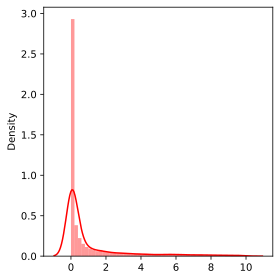

In [43]:
# Создаем пространство признаков для перебора RandomizedSearchCV из соответствующего расспределения
from scipy.stats import uniform, norm, lognorm, loguniform

C_range = loguniform(1e-3, 10).rvs(10000, random_state=42).round(3)

fig, axes = plt.subplots(figsize=(4,4))
sns.distplot(C_range, ax=axes, color='r')
plt.tight_layout()

In [ ]:
df = pd.read_csv('Bank_Customer_Churn_Prediction.csv', index_col=0)

df.loc[df.sample(30).index, 'tenure'] = np.nan
X = df.drop(columns='churn')
y = df.churn

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

max_depth_range = range(1,20)
estimators_range = range(1,100)

params = [{
    'clf': [LogisticRegression(random_state=42, tol=0.01)],
    'clf__solver': ['saga', 'liblinear'],
    'clf__penalty': ['l2', 'l1'],
    'clf__C': C_range,
    'columntransformer__pipeline__standardscaler': [MinMaxScaler(), StandardScaler()],
    'feature_select__k': [5, 10, 'all'],    
    },
        
    {
        'clf': [RandomForestClassifier(random_state=42)],
        'clf__n_estimators': estimators_range,
        'clf__max_depth': max_depth_range,
        'clf__max_features': [None, 'sqrt', 5,],
        'feature_select__k' : [5, 10, 'all'],
        'columntransformer__pipeline__standardscaler': [None, StandardScaler()],
        'columntransformer__pipeline__dropcorrelatedfeatures__threshold': [0.6, 0.7, 0.8, 0.9]
    },

    {
        'clf': [DecisionTreeClassifier(random_state=42)],
        'clf__max_depth': max_depth_range,
        'columntransformer__pipeline__dropcorrelatedfeatures': [None, StandardScaler()],
        'feature_select__k' : [5, 10, 'all']
    }

]

grid = RandomizedSearchCV(pipeline,
                    params,
                    n_iter=30,
                    cv=3,
                    verbose=5,
                    random_state=42,
                    scoring='f1',
                    n_jobs=-1)

In [ ]:
%%time
grid.fit(X_train, y_train)

In [ ]:
grid.best_estimator_

In [ ]:
grid.best_params_

In [ ]:
grid.best_score_

In [ ]:
predicted = grid.predict(X_test)
f1_score(y_test, predicted).round(2)

In [ ]:
predicted_proba = grid.predict_proba(X_test)

In [ ]:
predicted_proba[:,1]>0.5